In [59]:
import warnings
import pandas as pd
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [60]:
data=pd.read_csv('./datasets/mod_03_topic_05_weather_data.csv.gz')
data.shape

(145460, 23)

In [61]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [62]:
# get info about feature types
data.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

In [63]:
# check for missed values
data.isna().mean().sort_values(ascending=False)

# drop rows in which missed values reach more than 35%
data=data[data.columns[data.isna().mean().lt(0.35)]]

# drop rows where target is missed
data=data.dropna(subset="RainTomorrow")

data.shape

(142193, 19)

In [64]:
# split data on numerical and categorical subsets
data_num=data.select_dtypes(include=np.number)
data_cat=data.select_dtypes(include='object')

In [65]:
# convert Date column to datetime type
data_cat["Date"]=pd.to_datetime(data['Date'])

# create two new columns 'Year' and 'Month'
data_cat[['Year', 'Month']]=(data_cat["Date"].apply(lambda x: pd.Series([x.year, x.month])))

# move 'Year' column to numerical features subset
data_num['Year']=data_cat['Year']

data_cat.drop(['Date','Year'], axis=1, inplace=True)

# check subsets
data_cat['Month'].head()
data_num["Year"].head()

0    2008
1    2008
2    2008
3    2008
4    2008
Name: Year, dtype: int64

In [66]:
# split on train and test datasets (test datasets include data for the last year, train dataset - the rest)
X_test_num=data_num[-365:]
X_test_cat=data_cat[-365:]

X_train_num=data_num[:-365]
X_train_cat=data_cat[:-365]

y_train=X_train_cat['RainTomorrow']
y_test=X_test_cat['RainTomorrow']

X_test_cat=X_test_cat.drop('RainTomorrow',axis=1)
X_train_cat=X_train_cat.drop('RainTomorrow',axis=1)

In [67]:
X_test_num

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Year
145093,3.2,17.9,NaN,44.0,11.0,20.0,83.0,39.0,1022.4,1019.0,8.8,17.2,2016
145094,8.8,11.3,0.6,35.0,15.0,20.0,85.0,99.0,1020.1,1014.9,10.8,11.1,2016
145095,10.2,15.6,42.0,43.0,19.0,24.0,95.0,52.0,1018.7,1018.4,10.5,14.9,2016
145096,2.9,16.4,0.0,35.0,15.0,20.0,88.0,51.0,1024.6,1021.9,8.4,15.9,2016
145097,3.4,17.2,0.0,39.0,17.0,19.0,82.0,41.0,1025.4,1021.5,8.5,16.7,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,3.5,21.8,0.0,31.0,15.0,13.0,59.0,27.0,1024.7,1021.2,9.4,20.9,2017
145455,2.8,23.4,0.0,31.0,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,2017
145456,3.6,25.3,0.0,22.0,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,2017
145457,5.4,26.9,0.0,37.0,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,2017


In [68]:
X_train_cat

,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,Month
0,Albury,W,W,WNW,No,12
1,Albury,WNW,NNW,WSW,No,12
2,Albury,WSW,W,WSW,No,12
3,Albury,NE,SE,E,No,12
4,Albury,W,ENE,NW,No,12
...,...,...,...,...,...,...
145086,Uluru,NaN,NaN,NaN,No,6
145087,Uluru,NaN,NaN,NaN,No,6
145088,Uluru,NaN,NaN,NaN,No,6
145089,Uluru,NaN,NaN,NaN,No,6


In [69]:
# restore missed data to mean value for numerical data
num_imputer=SimpleImputer().set_output(transform='pandas')
X_train_num=num_imputer.fit_transform(X_train_num)
X_test_num=num_imputer.transform(X_test_num)

pd.concat([X_train_num, X_test_num]).isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
Year             0
dtype: int64

In [70]:
# restore missed data to mode value for categorical data
cat_imputer=SimpleImputer(strategy='most_frequent').set_output(transform='pandas')
X_train_cat=cat_imputer.fit_transform(X_train_cat)
X_test_cat=cat_imputer.transform(X_test_cat)

pd.concat([X_train_cat, X_test_cat]).isna().sum()

Location       0
WindGustDir    0
WindDir9am     0
WindDir3pm     0
RainToday      0
Month          0
dtype: int64

In [71]:
# perform numeric features normalization
scaler=StandardScaler().set_output(transform='pandas')
X_train_num=scaler.fit_transform(X_train_num)
X_test_num=scaler.transform(X_test_num)

In [72]:
# encode categorical data
encoder=(OneHotEncoder(drop='if_binary',sparse_output=False).set_output(transform='pandas'))
X_train_cat=encoder.fit_transform(X_train_cat)
X_test_cat=encoder.transform(X_test_cat)

X_train_cat.shape

(141828, 110)

In [79]:
X_test_cat.shape

(365, 110)

In [73]:
# concat categorical and numeric subsets for model creation
X_train=pd.concat([X_train_num, X_train_cat], axis=1)
X_test=pd.concat([X_test_num, X_test_cat], axis=1)

X_train.shape

(141828, 123)

In [74]:
# check target value distribution
y_train.value_counts(normalize=True)

RainTomorrow
No     0.77551
Yes    0.22449
Name: proportion, dtype: float64

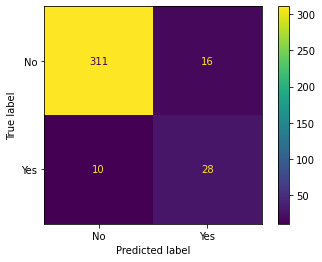

              precision    recall  f1-score   support

          No       0.97      0.95      0.96       327
         Yes       0.64      0.74      0.68        38

    accuracy                           0.93       365
   macro avg       0.80      0.84      0.82       365
weighted avg       0.93      0.93      0.93       365



In [75]:
# build LogisticRegression training model with parameters solver='liblinear' and class_weight='balanced' to encount disbalance of the target value
clf=(LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42).fit(X_train, y_train))

pred=clf.predict(X_test)


# build confusion matrix to observe results
ConfusionMatrixDisplay.from_predictions(y_test, pred)

plt.show()

# get accuracy metrics using classification_report method
print(classification_report(y_test, pred))

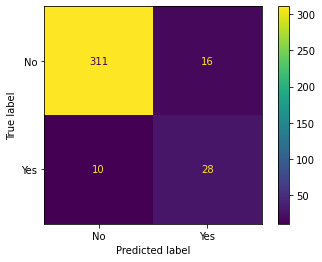

              precision    recall  f1-score   support

          No       0.97      0.95      0.96       327
         Yes       0.64      0.74      0.68        38

    accuracy                           0.93       365
   macro avg       0.80      0.84      0.82       365
weighted avg       0.93      0.93      0.93       365



In [76]:
# build LogisticRegression training model with parameters solver='newton-cholesky' and class_weight='balanced' to encount disbalance of the target value
clf=(LogisticRegression(solver='newton-cholesky', class_weight='balanced', random_state=42).fit(X_train, y_train))

pred=clf.predict(X_test)


# build confusion matrix to observe results
ConfusionMatrixDisplay.from_predictions(y_test, pred)

plt.show()

# get accuracy metrics using classification_report method
print(classification_report(y_test, pred))

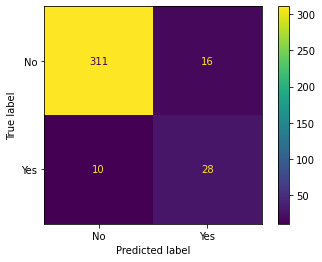

              precision    recall  f1-score   support

          No       0.97      0.95      0.96       327
         Yes       0.64      0.74      0.68        38

    accuracy                           0.93       365
   macro avg       0.80      0.84      0.82       365
weighted avg       0.93      0.93      0.93       365



In [77]:
# build LogisticRegression training model with parameters solver='newton-cholesky' and class_weight='balanced' to encount disbalance of the target value
clf=(LogisticRegression(solver='saga', class_weight='balanced', random_state=42).fit(X_train, y_train))

pred=clf.predict(X_test)


# build confusion matrix to observe results
ConfusionMatrixDisplay.from_predictions(y_test, pred)

plt.show()

# get accuracy metrics using classification_report method
print(classification_report(y_test, pred))

In [78]:
# Conclusion, we have build LogisticRegression model for Rain prediction and obtained results with high accuracy 93%, as well as all other accuracy metrics that are in range from 95%-97%. These results are much better as results in our practical lesson model. We can make a conclusion that splitting our dataset on train and test subsets using last year as conditional "future" period allows us to improve our model prediction significantly in comparison with just usual train_test_split method.  